# Imaging systematic mitigation: the QSO case

**author:** Edmond Chaussidon (CEA Saclay)

**mail:** edmond.chaussidon@cea.fr

This notebook is based on the test case which are saved in `regressis/tests/test_cas_qso/`.

In [1]:
import os
import logging

from regressis import PhotometricDataFrame, Regression, DR9Footprint
from regressis.utils import setup_logging, setup_mplstyle

In [2]:
logger = logging.getLogger('Notebook')
setup_logging()

# On NERSC, you may need to load tex with `module load texlive`
# With you don't want please comment the following line
setup_mplstyle()


## 1. Load data:


In [3]:
# Information about version (SV3 / MAIN / DA02 / Y1 / ...) and the tracer chosen:
version, tracer, suffix_tracer = 'SV3', 'QSO', ''

# Load DR9 footprint:
dr9_footprint = DR9Footprint(256, mask_lmc=True, clear_south=True, mask_around_des=True, cut_desi=False)

# Set parameters for the dataframe:
# You can save some figures setting 'output_dir' not None
params = dict()
params['data_dir'] = '../regressis/tests/test_case_qso'
params['output_dir'] = None
params['use_median'] = False
params['use_new_norm'] = True
params['regions'] = ['North', 'South', 'Des']

# Build PhotometricDataFrame class:
dataframe = PhotometricDataFrame(version, tracer, dr9_footprint, suffix_tracer, **params)

# Load features from params['data_dir']:
logger.info('Features')
dataframe.set_features() 

# Load targets from params['data_dir'] and default fracarea (FRACAREA_12290 from features):
logger.info('Targets')
dataframe.set_targets()

# Select which pixels will be kept for the training and compute the normalized density on each selected params['regions']:
logger.info('Build')
dataframe.build(cut_fracarea=True)

[000000.01] 22-01-10 03:08  Footprint            INFO     Load DR9 footprint with mask_lmc=True, clear_south=True, mask_around_des=True and cut_desi=False
[000000.04] 22-01-10 03:08  DataFrame            INFO     version: SV3 -- tracer: QSO -- regions: ['North', 'South', 'Des']
[000000.05] 22-01-10 03:08  Notebook             INFO     Features
[000000.05] 22-01-10 03:08  DataFrame            INFO     Read ../regressis/tests/test_case_qso/pixweight-dr9-256.fits
[000000.52] 22-01-10 03:08  DataFrame            INFO     Read ../regressis/tests/test_case_qso/sagittarius_stream_256.npy
[000000.59] 22-01-10 03:08  DataFrame            INFO     Sanity check: number of NaNs in features: 0
[000000.60] 22-01-10 03:08  Notebook             INFO     Targets
[000000.60] 22-01-10 03:08  DataFrame            INFO     Read ../regressis/tests/test_case_qso/SV3_QSO_256.npy
[000000.60] 22-01-10 03:08  DataFrame            INFO     Do not find corresponding fracarea map --> use FRACAREA_12290 as default f

In [4]:
# Features, targets, fracarea can be pass 
# either given the array containing the data 
# or given the correct path where the file is (features is .fits and sgr_stream/targets/fracarea is .npy)

# Load features from params['data_dir']:
logger.info('Features')
feature_path = '../regressis/tests/test_case_qso/pixweight-dr9-256.fits'
stream_path = '../regressis/tests/test_case_qso/sagittarius_stream_256.npy'
use_stream = True # is set False, do not load sgr stream feature map.
dataframe.set_features(pixmap=feature_path, sgr_stream=stream_path, use_sgr_stream=use_stream) 

# Load targets from params['data_dir'] and default fracarea (FRACAREA_12290 from features):
logger.info('Targets')
target_path = '../regressis/tests/test_case_qso/SV3_QSO_256.npy'
dataframe.set_targets(targets=target_path, fracarea=None)

# Select which pixels will be kept for the training and compute the normalized density on each selected params['regions']:
logger.info('Build')
dataframe.build(cut_fracarea=True)

[000004.76] 22-01-10 03:08  Notebook             INFO     Features
[000004.76] 22-01-10 03:08  DataFrame            INFO     Read ../regressis/tests/test_case_qso/pixweight-dr9-256.fits
[000005.20] 22-01-10 03:08  DataFrame            INFO     Read ../regressis/tests/test_case_qso/sagittarius_stream_256.npy
[000005.28] 22-01-10 03:08  DataFrame            INFO     Sanity check: number of NaNs in features: 0
[000005.28] 22-01-10 03:08  Notebook             INFO     Targets
[000005.28] 22-01-10 03:08  DataFrame            INFO     Read ../regressis/tests/test_case_qso/SV3_QSO_256.npy
[000005.28] 22-01-10 03:08  DataFrame            INFO     Do not find corresponding fracarea map --> use FRACAREA_12290 as default fracarea
[000005.28] 22-01-10 03:08  DataFrame            INFO     Read ../regressis/tests/test_case_qso/pixweight-dr9-256.fits
[000005.36] 22-01-10 03:08  Notebook             INFO     Build
[000006.09] 22-01-10 03:08  DataFrame            INFO     The considered footprint repre

## 2. Run regression:

In [5]:
# Parametrization of regression and launch it:
# regressor could be 'RF', 'NN', 'LINEAR'
# suffix_regressor is used only to build the output directory (if is output_dir not None). 
# Useful to run different hyperparameters on the same dataset.

# Which features will be used during the regression. 
# Have to be loaded from feature_pixmap with dataframe.set_features(sel_columns).
feature_names = ['STARDENS', 'EBV', 'STREAM',
                 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2',
                 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']

# Some plots are drawn and saved if dataframe.output_dir is not None

# Use kfold training/eval to avoid overfitting !!
use_kfold = False

# If regressor_params is None, uses default parametrization defined in regression.py
# Update specific parameter with e.g. {'North':{'min_sample_leaf':20}}
regressor_params=None

# If nfold_params is None, uses default parametrization defined in regression.py
nfold_params = {'North':6, 'South':12, 'Des':6}

regression = Regression(dataframe, feature_names=feature_names,
                        regressor_params=regressor_params, nfold_params=nfold_params,
                        regressor='LINEAR', suffix_regressor='', use_kfold=use_kfold,
                        n_jobs=6, seed=123)

[000009.46] 22-01-10 03:08  Regression           INFO     We use the set of features: ['STARDENS', 'EBV', 'STREAM', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']
[000009.46] 22-01-10 03:08  Regression           WARNING  k-fold training not used
[000010.59] 22-01-10 03:08  Regression           INFO       ** North :
[000010.64] 22-01-10 03:08  Regression           INFO         --> Sample size North: 96329 -- Total sample size: 358139 -- Training fraction: 26.90%
[000010.65] 22-01-10 03:08  Regression           INFO         --> Use k-fold training ? False
[000010.65] 22-01-10 03:08  Regression           INFO         --> Engine: LINEAR with params: {}
[000010.65] 22-01-10 03:08  Regression           INFO               --> All features (except the STREAM) are normalized and centered on the training footprint
[000010.76] 22-01-10 03:08  Regression           INFO               --> Mean of mean and std on the fold-training featur

In [6]:
# choose a specific savedir or default directory will be used (only available if dataframe.output_dir is not None)
wsys = regression.get_weight(save=False)

## 3. Some plots:

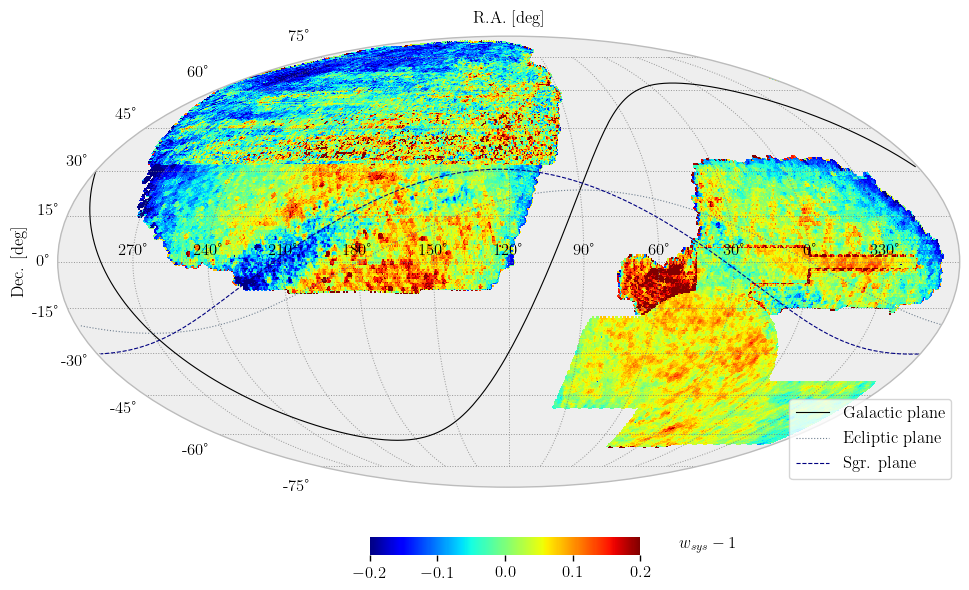

In [7]:
# Some utilitaries for plotting are provided in regressis/plots.py regressis/systematics.py

from regressis.plot import plot_moll
import numpy as np

# to avoid warning due to comparaison with np.nan values.
with np.errstate(divide='ignore', invalid='ignore'):
    plot_moll(wsys.map-1, min=-0.2, max=0.2, label='$w_{sys} - 1$',
              galactic_plane=True, ecliptic_plane=True, sgr_plane=True, labelpad=-30)

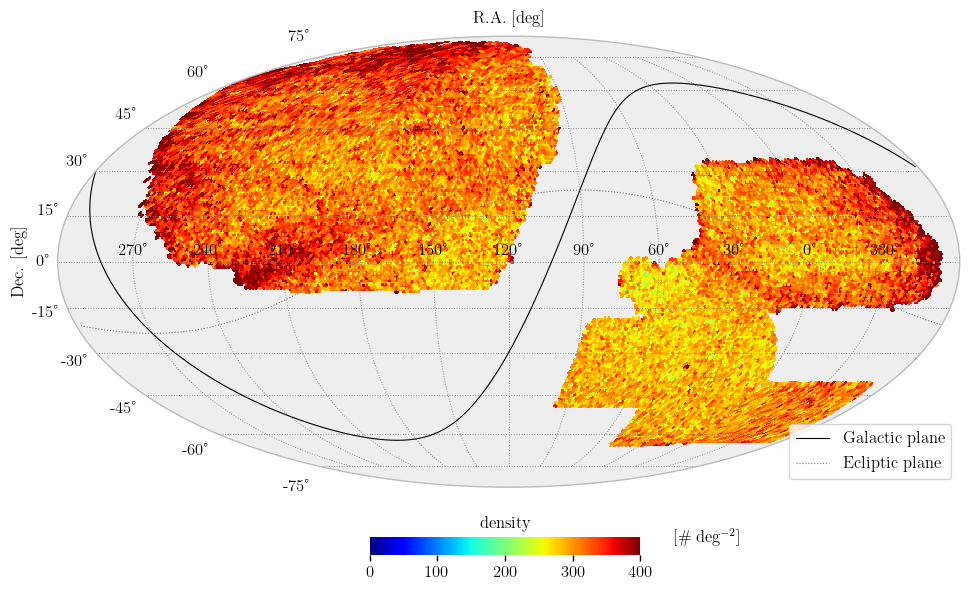

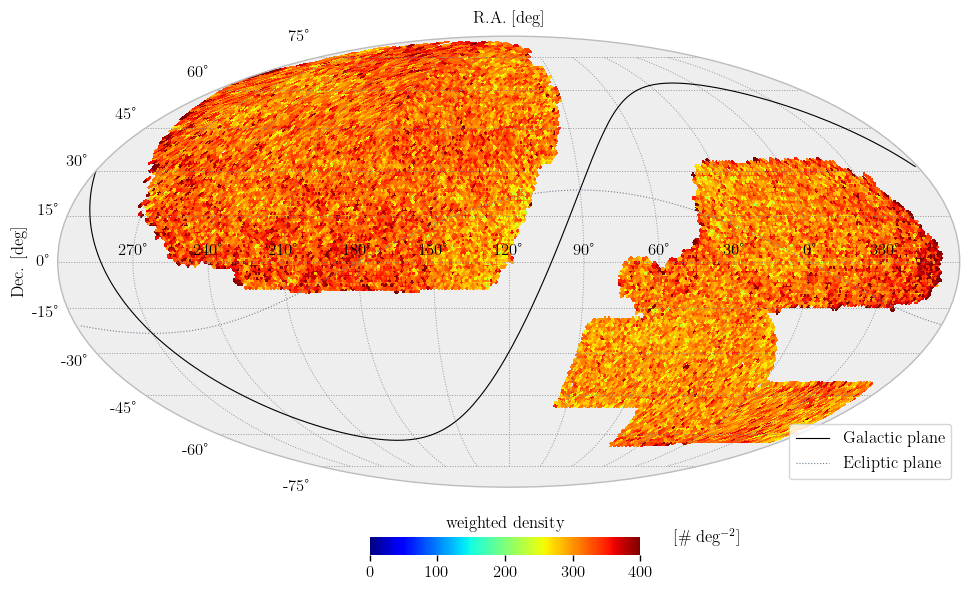

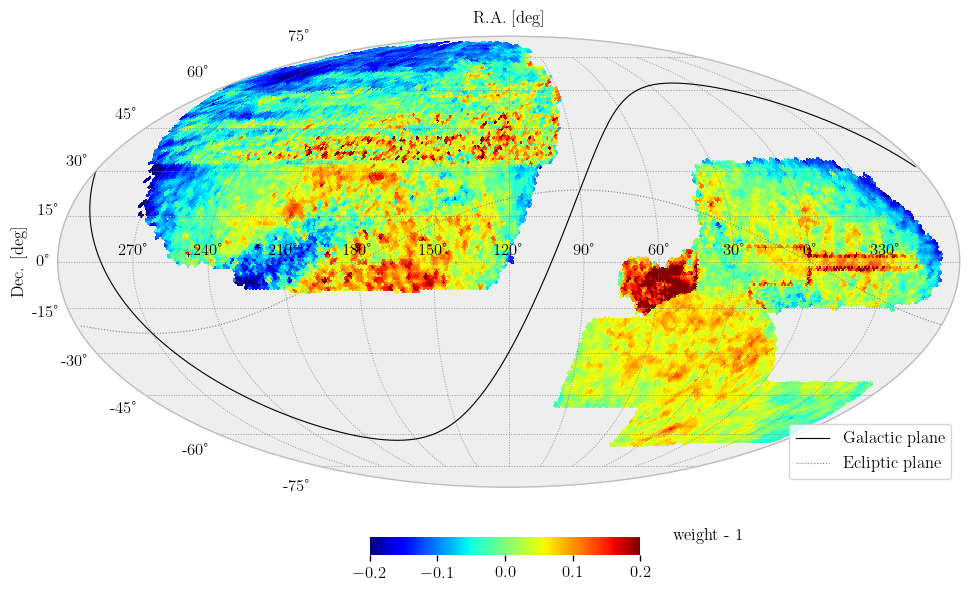

[000020.17] 22-01-10 03:08  Systematics          INFO     Work with North
[000021.21] 22-01-10 03:08  Systematics          INFO     Keep only pixels with fracarea > 0


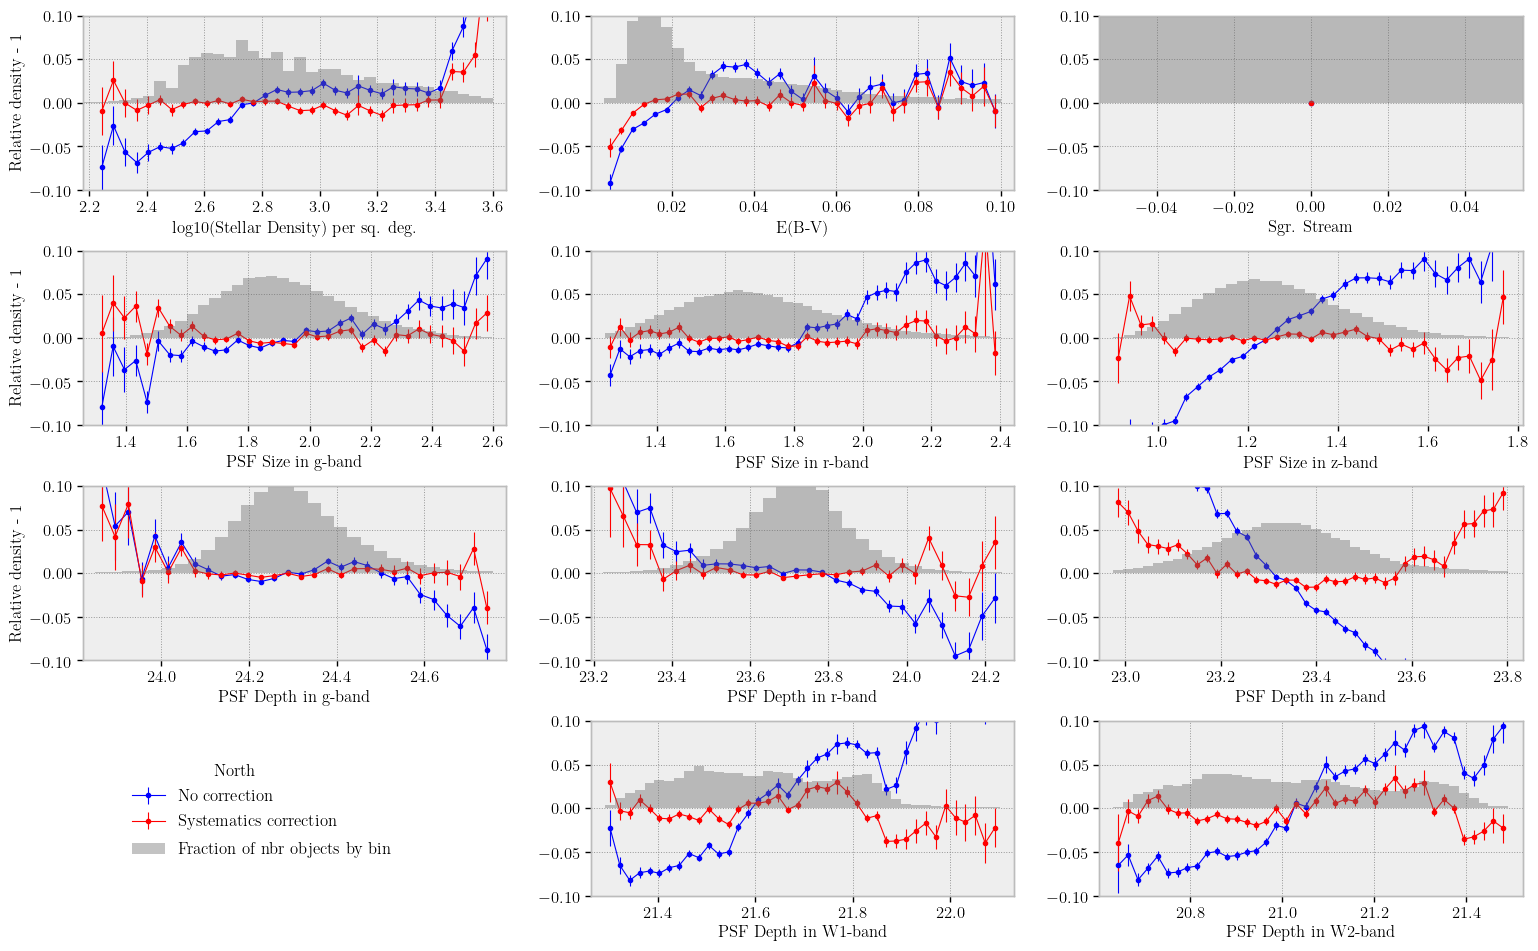

[000024.95] 22-01-10 03:08  Systematics          INFO     Work with South
[000025.94] 22-01-10 03:08  Systematics          INFO     Keep only pixels with fracarea > 0


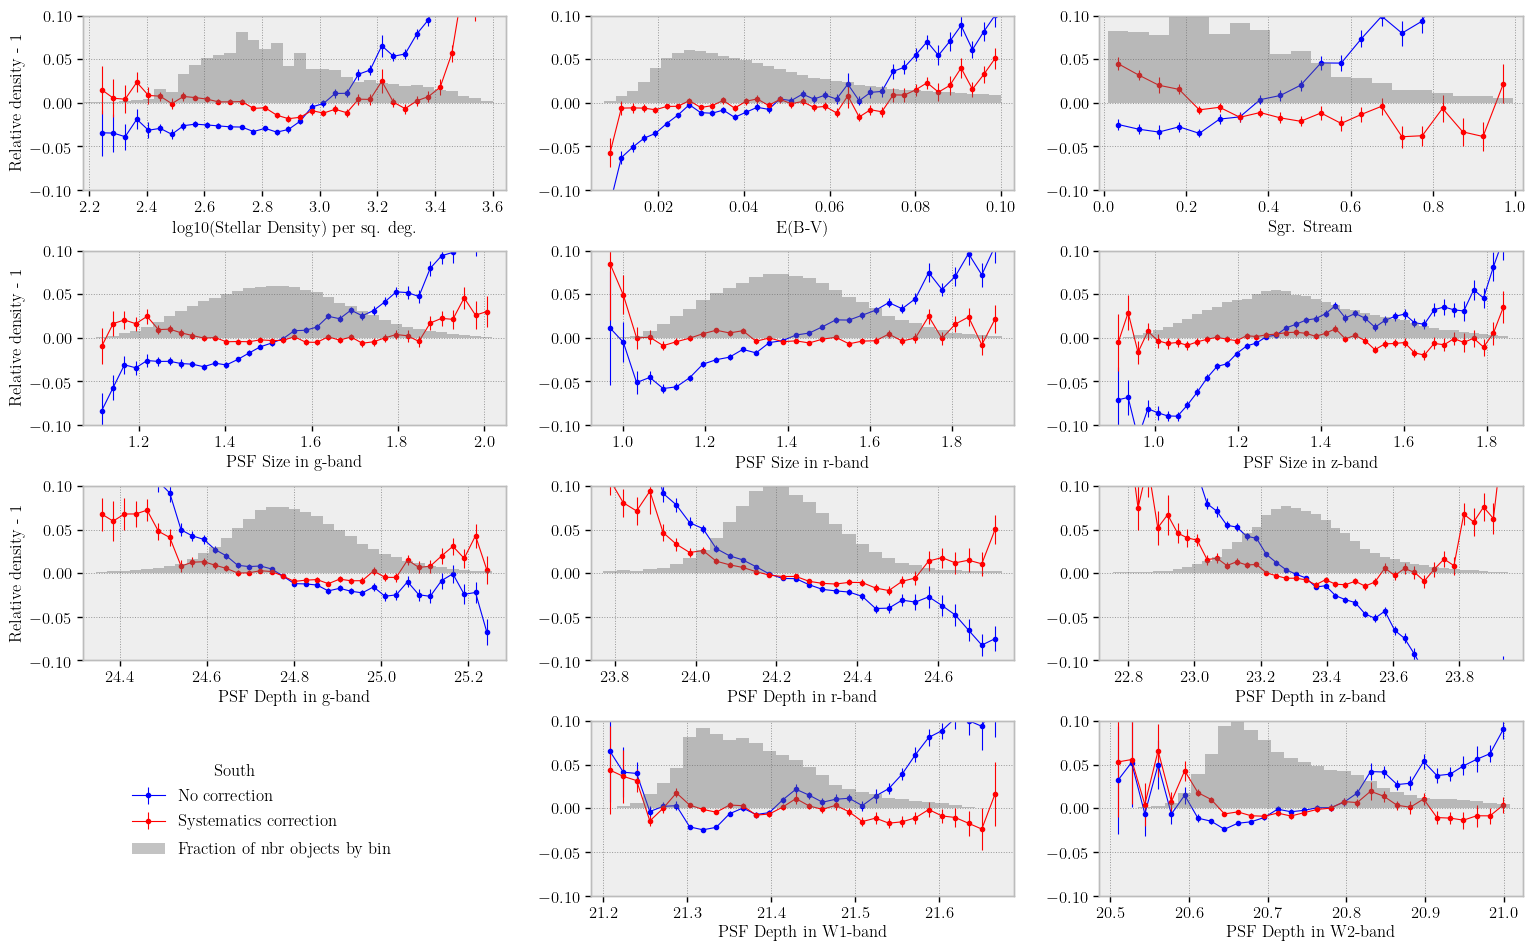

[000030.03] 22-01-10 03:08  Systematics          INFO     Work with Des
[000031.01] 22-01-10 03:08  Systematics          INFO     Keep only pixels with fracarea > 0


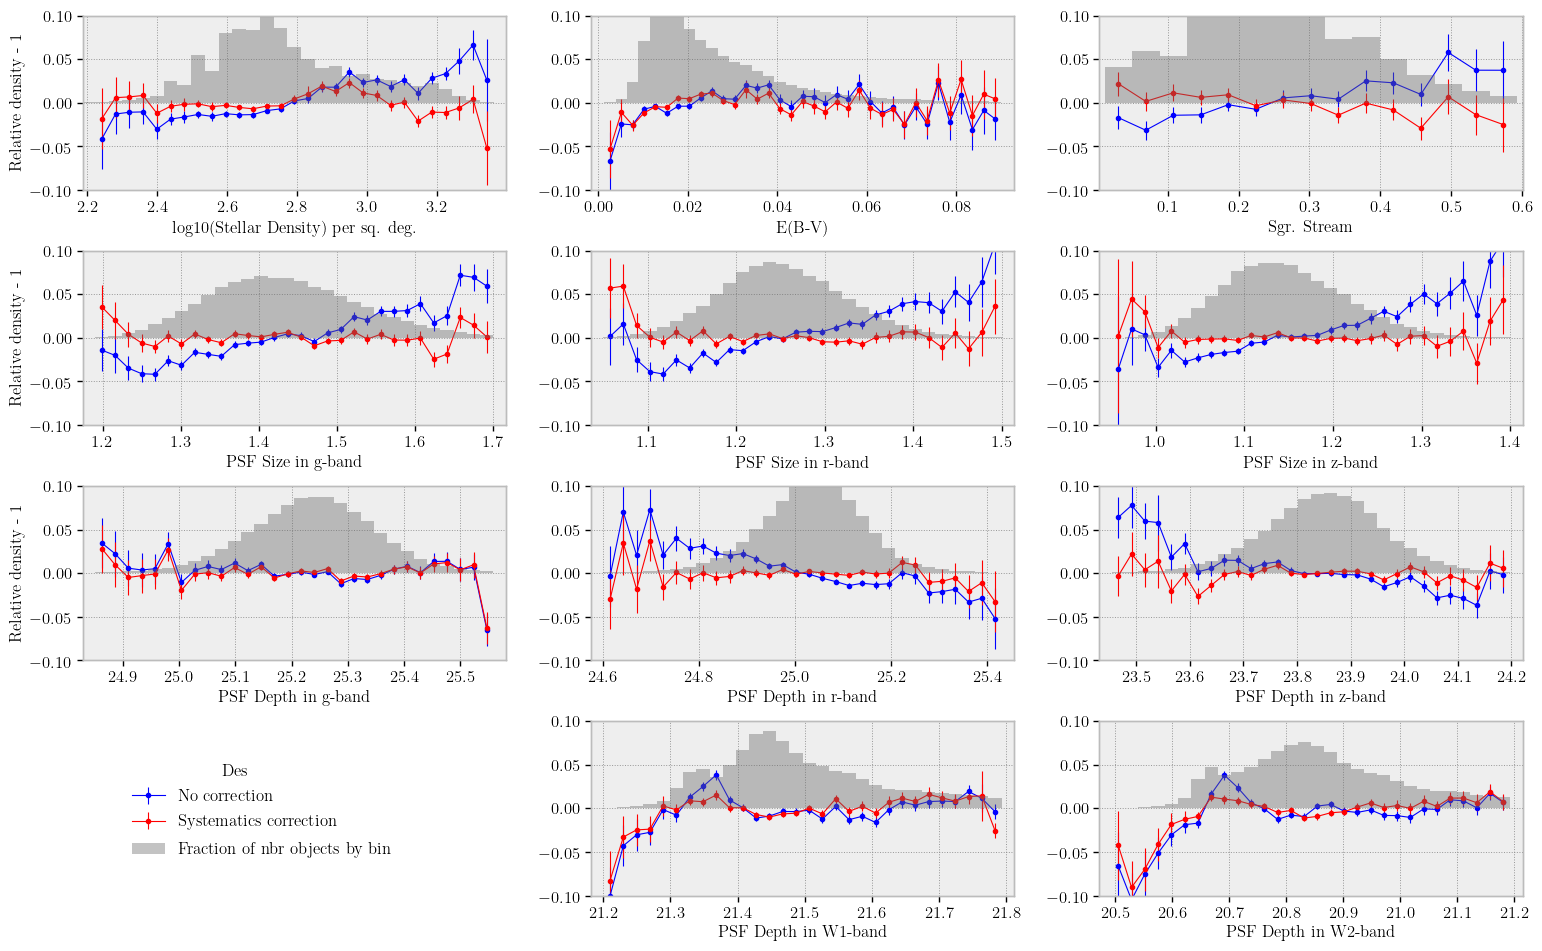

In [8]:
# Can also used pre-defined functions from regression class:

regression.plot_maps_and_systematics(max_plot_cart=400, cut_fracarea=False, show=True, save=False, ax_lim=0.1)